In [1]:
import numpy as np
import pandas as pd
import datetime
import pickle
import re

# 統計モデル
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

# グラフ描画
from matplotlib import pylab as plt
import seaborn as sns
%matplotlib inline
sns.set()

# 誤差の評価
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# ワーニングを表示させない
import warnings
warnings.filterwarnings('ignore')

In [2]:
inputDir = "/home/onimem/work/Open_world/NBA/Graph"
outputDir = "/home/onimem/work/Open_world/NBA/Model"

# 時系列グラフの読み込み
with open(inputDir + '/nba.graph', mode='rb') as f:
    graph = pickle.load(f)

In [3]:
# データ構造確認

YEAR = 1950
NAME = 'Curly Armstrong'

print("num of years : ", len(graph))
print("size of graph per year : (nodes and edges)", len(graph[YEAR]))
print("num of nodes : ", len(graph[YEAR]['nodes']))
print("num of attributes : ", len(graph[YEAR]['nodes'][NAME]))
print("type of edges : ", len(graph[YEAR]['edges']))
print("num of team edges : ", len(graph[YEAR]['edges']['team']))

num of years :  68
size of graph per year : (nodes and edges) 2
num of nodes :  223
num of attributes :  15
type of edges :  1
num of team edges :  2794


In [4]:
def is_unique(seq):
    return len(seq) == len(set(seq))

def new_node(y1nodes, y2nodes):
    if is_unique(y1nodes) and is_unique(y2nodes):
        newnodes = set(y2nodes) - set(y1nodes)
        return len(newnodes)
    else :
        print("error")
        exit()

def loss_node(y1nodes, y2nodes):
    if is_unique(y1nodes) and is_unique(y2nodes):
        lossnodes = set(y1nodes) - set(y2nodes)
        return len(lossnodes)
    else :
        print("error")
        exit()

def plot_history(history, x, y, title):
    plt.plot(history[x], history[y], marker=".", label=y, color='#1ea8b5')
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    plt.show()
    
def plot_history2(history, x, y1, y2, title, ylabel):
    plt.plot(history[x], history[y1], marker=".", color='#1ea8b5', label=y1)
    plt.plot(history[x], history[y2], marker=".", color='#ce405f', label=y2)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

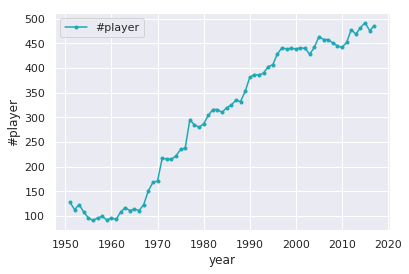

In [5]:
# NBA全体の競技人口をプロット
# 1950年データは異常値のため使用しない

x = "year"
years = [i for i in range(1951, 2018)]

y = "#player"
num_player = []
for year in years:
    num_player.append(len(graph[year]['nodes']))

history = {x:years, y:num_player}
plot_history(history, x, y, title="")


# graphデータ構造をactive teamでグルーピング : graph_tm
activeteam = ['ATL', 'BRK', 'BOS', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHO', 'PHI', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS']

# graph per team
graph_tm = {}
for tm in activeteam:
    graph_tm[tm] = {}
    for year in years:
        graph_tm[tm][year] = {}
        for name, attribute in graph[year]['nodes'].items():
            if attribute["Tm"] == tm:
                graph_tm[tm][year][name] = graph[year]['nodes'][name]

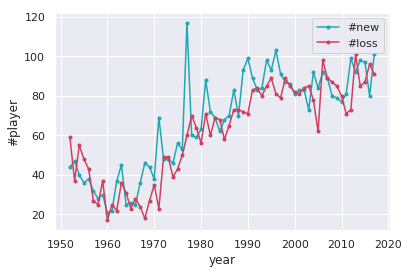

In [6]:
# NBA全体で新たに出現するノード数と消失するノード数をプロット
# 1950年データは異常値のため使用しない

x = "year"
years_1 = [i for i in range(1952, 2018)] # 差分を調べるためのyearリスト

y1 = "#new"
new_player = []
for year in years_1:
    diff = new_node(graph[year-1]['nodes'], graph[year]['nodes'])
    new_player.append(diff)

y2 = "#loss"
loss_player = []
for year in years_1:
    diff = loss_node(graph[year-1]['nodes'], graph[year]['nodes'])
    loss_player.append(diff)

history = {x:years_1, y1:new_player, y2:loss_player}
plot_history2(history, x, y1, y2, title="", ylabel="#player")

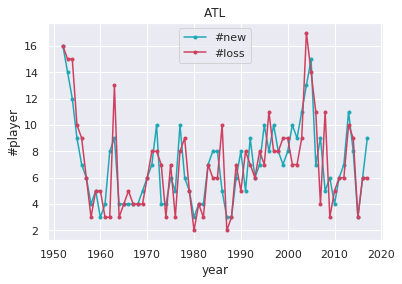

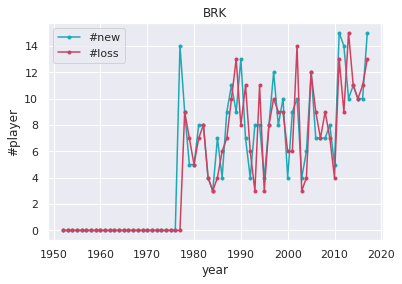

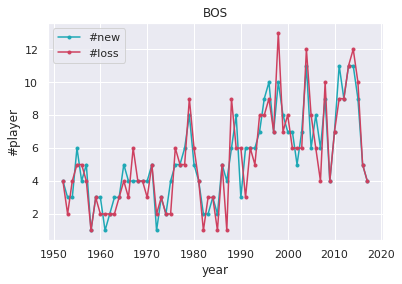

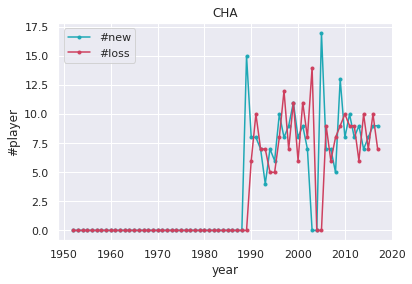

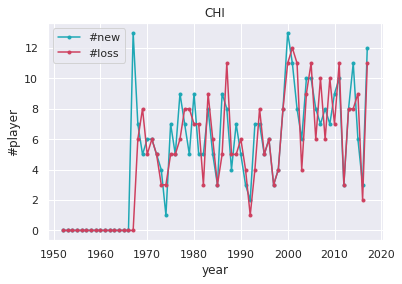

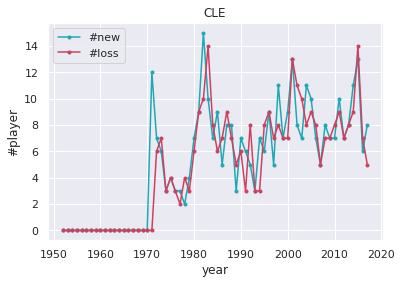

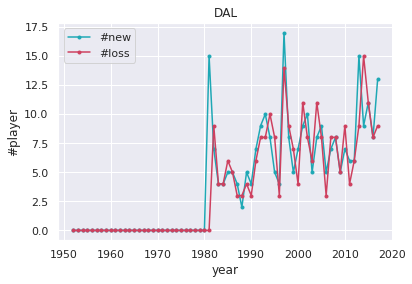

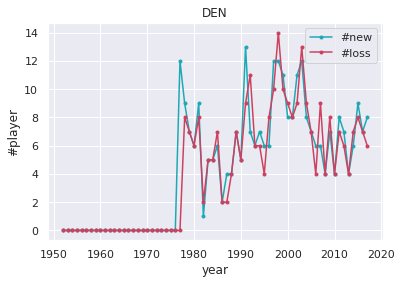

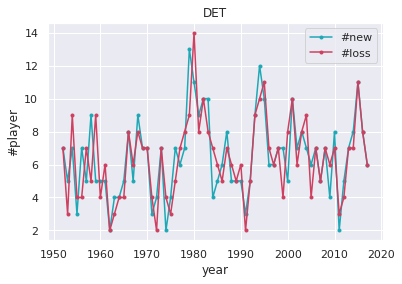

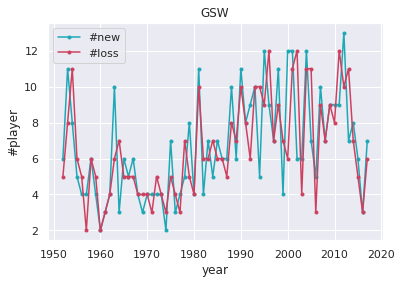

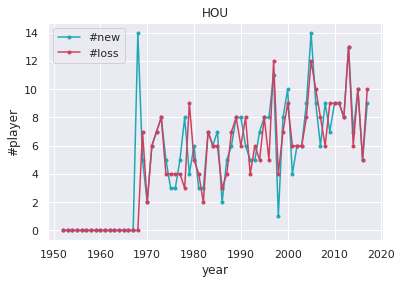

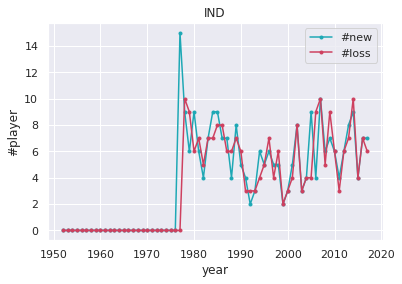

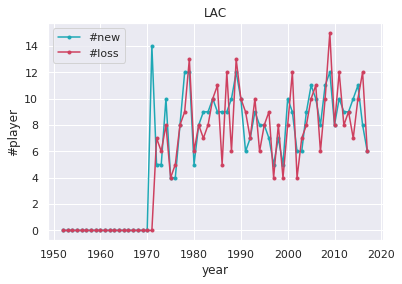

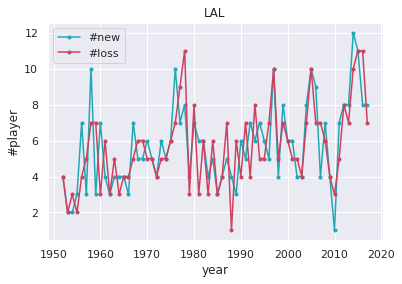

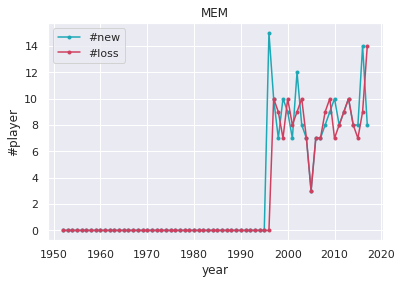

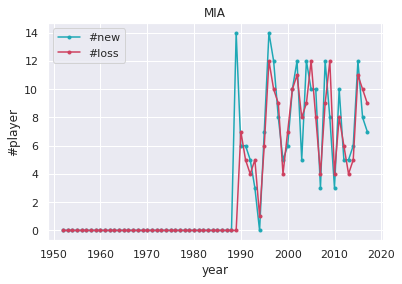

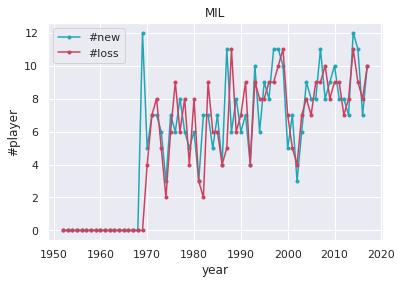

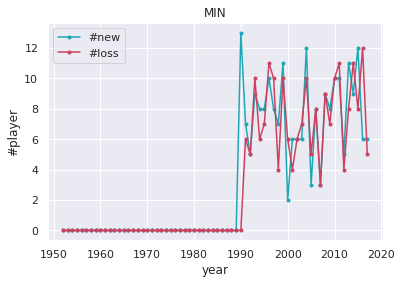

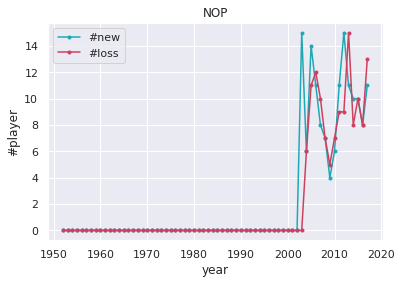

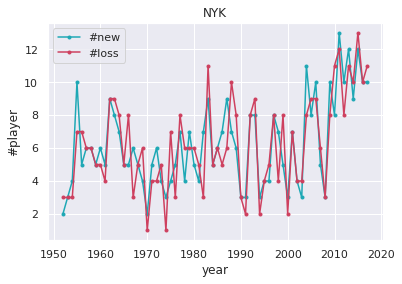

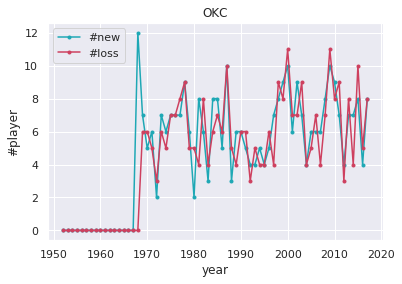

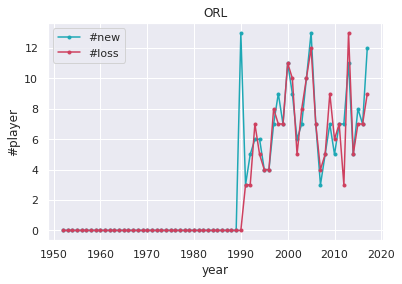

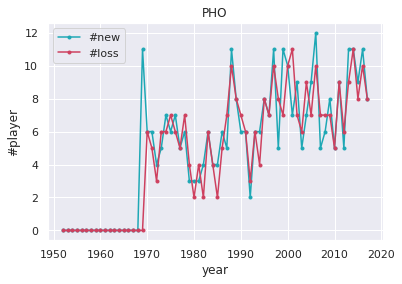

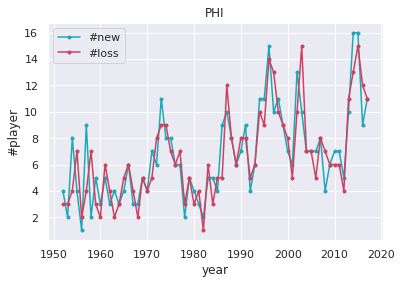

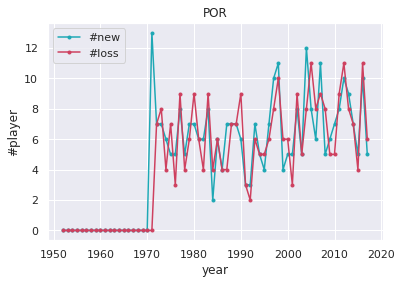

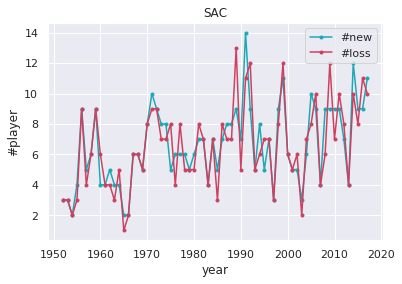

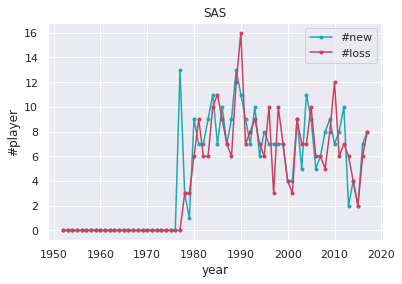

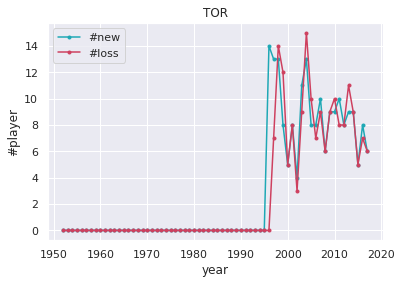

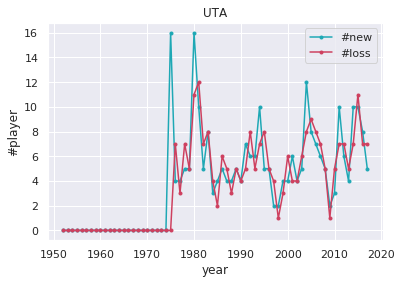

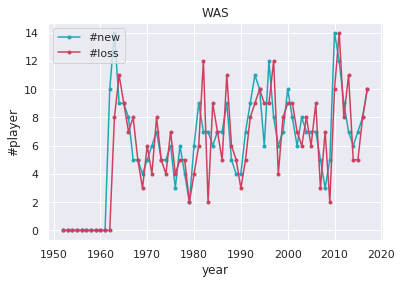

In [7]:
# 新たに出現するノード数と消失するノード数をチームごとにプロット
x = "year"
years_1 = [i for i in range(1952, 2018)] # 差分を調べるためのyearリスト

for tm, graph in graph_tm.items():
    y1 = "#new"
    new_player = []
    
    for year in years_1:
        diff = new_node(graph[year-1], graph[year])
        new_player.append(diff)
    
    y2 = "#loss"
    loss_player = []
    for year in years_1:
        diff = loss_node(graph[year-1], graph[year])
        loss_player.append(diff)
    
    history = {x:years_1, y1:new_player, y2:loss_player}
    plot_history2(history, x, y1, y2, title=tm, ylabel="#player")

In [8]:
def ParamEstimate(ts):
    # 総当たりで、AICが最小となるARIMAの次数を探す
    max_p = 3
    max_q = 3
    max_d = 1
    
    pattern = max_p*(max_q + 1)*(max_d + 1)
    modelSelection = pd.DataFrame(index=range(pattern), columns=["model", "aic"])
    
    # 自動ARIMA選択
    num = 0
    
    # 『enforce_stationarity = False』『enforce_invertibility = False』を指定するためSARIMAX関数を使用している
    for p in range(1, max_p + 1):
        for d in range(0, max_d + 1):
            for q in range(0, max_q + 1):
                arima = sm.tsa.SARIMAX(
                    ts, order=(p,d,q), 
                    enforce_stationarity = False,
                    enforce_invertibility = False
                ).fit()
                modelSelection.ix[num]["model"] = "order=(" + str(p) + ","+ str(d) + ","+ str(q) + ")"
                modelSelection.ix[num]["aic"] = arima.aic
                num = num + 1
    return modelSelection[modelSelection.aic == min(modelSelection.aic)]

patternの数の計算式においてmax_pだけプラス1されていないが、これは誤植ではない。ARIMAモデルのAR項の次数を０にして実行すると、エラーが頻発してしまったため、あえてAR項は「最低次数は１とする」という条件でループさせる。  
参考　https://logics-of-blue.com/python-time-series-analysis/

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   58
Model:               SARIMAX(1, 1, 3)   Log Likelihood                -118.031
Date:                Tue, 18 Dec 2018   AIC                            246.062
Time:                        12:52:00   BIC                            255.913
Sample:                    01-01-1952   HQIC                           249.850
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2587      0.521      0.497      0.619      -0.762       1.280
ma.L1         -0.9251      0.419     -2.208      0.027      -1.746      -0.104
ma.L2          0.0413      0.396      0.104      0.9

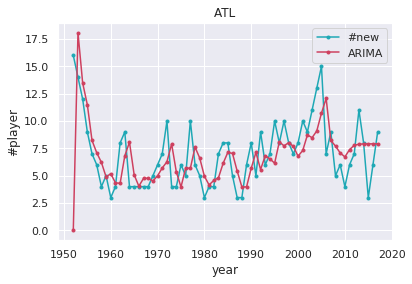

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   33
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 -67.785
Date:                Tue, 18 Dec 2018   AIC                            145.569
Time:                        12:52:01   BIC                            152.230
Sample:                    01-01-1977   HQIC                           147.606
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2311      0.773     -0.299      0.765      -1.745       1.283
ma.L1         -0.5930      0.892     -0.665      0.506      -2.341       1.155
ma.L2         -0.5719      0.578     -0.989      0.3

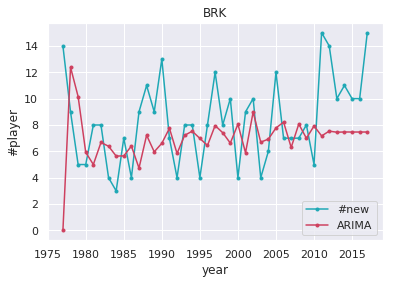

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   58
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -102.558
Date:                Tue, 18 Dec 2018   AIC                            217.116
Time:                        12:52:03   BIC                            228.938
Sample:                    01-01-1952   HQIC                           221.662
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1857      0.158      7.502      0.000       0.876       1.495
ar.L2         -0.6751      0.146     -4.636      0.000      -0.961      -0.390
ma.L1         -1.9543    226.884     -0.009      0.9

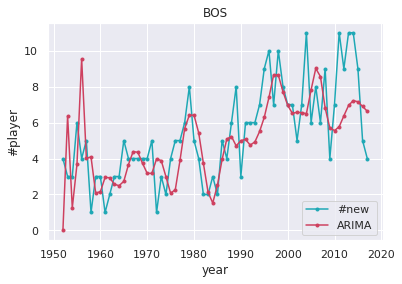

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   19
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 -35.966
Date:                Tue, 18 Dec 2018   AIC                             81.932
Time:                        12:52:03   BIC                             85.127
Sample:                             0   HQIC                            81.636
                                 - 19                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9500      0.455     -2.089      0.037      -1.841      -0.059
ma.L1          1.6550   1.13e+05   1.46e-05      1.000   -2.22e+05    2.22e+05
ma.L2         -1.5493   2.36e+04  -6.55e-05      1.0

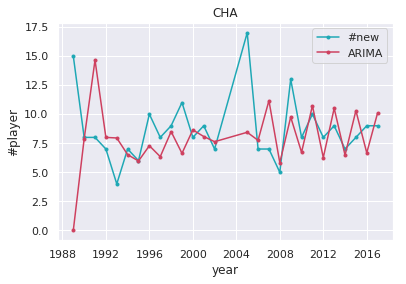

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   43
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 -86.595
Date:                Tue, 18 Dec 2018   AIC                            183.190
Time:                        12:52:05   BIC                            191.378
Sample:                    01-01-1967   HQIC                           186.103
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7371      0.211     -3.490      0.000      -1.151      -0.323
ma.L1          0.2864   7897.287   3.63e-05      1.000   -1.55e+04    1.55e+04
ma.L2         -0.8650   5635.426     -0.000      1.0

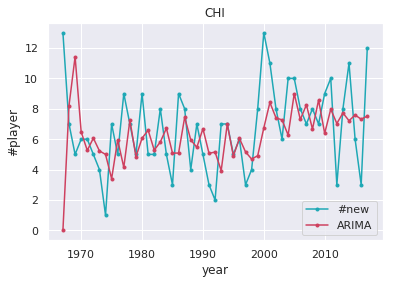

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   39
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 -83.548
Date:                Tue, 18 Dec 2018   AIC                            177.096
Time:                        12:52:06   BIC                            184.728
Sample:                    01-01-1971   HQIC                           179.699
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4297      3.042     -0.141      0.888      -6.391       5.532
ma.L1         -0.0783      3.019     -0.026      0.979      -5.996       5.840
ma.L2         -0.2616      1.502     -0.174      0.8

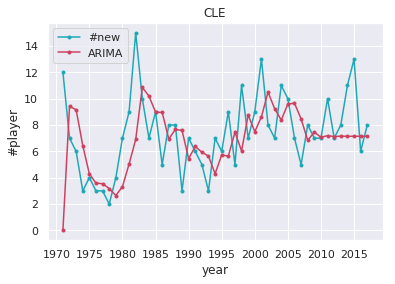

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   29
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 -59.655
Date:                Tue, 18 Dec 2018   AIC                            129.310
Time:                        12:52:06   BIC                            135.201
Sample:                    01-01-1981   HQIC                           130.873
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1329      0.606      0.219      0.826      -1.055       1.321
ma.L1         -1.0045      0.759     -1.324      0.185      -2.491       0.482
ma.L2         -0.0704      0.710     -0.099      0.9

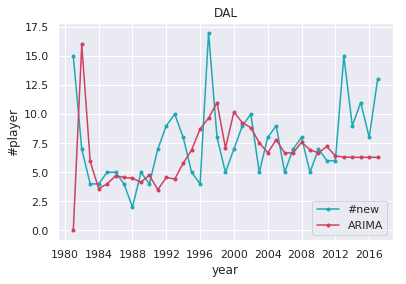

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   33
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 -62.436
Date:                Tue, 18 Dec 2018   AIC                            134.873
Time:                        12:52:08   BIC                            141.534
Sample:                    01-01-1977   HQIC                           136.909
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9292      0.011    -82.096      0.000      -0.951      -0.907
ma.L1          1.1431   1825.070      0.001      1.000   -3575.928    3578.215
ma.L2         -0.6989    275.273     -0.003      0.9

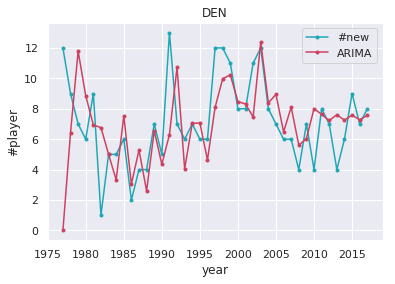

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   58
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -117.564
Date:                Tue, 18 Dec 2018   AIC                            247.128
Time:                        12:52:09   BIC                            258.950
Sample:                    01-01-1952   HQIC                           251.674
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9764      0.408      2.394      0.017       0.177       1.776
ar.L2         -0.6099      0.283     -2.157      0.031      -1.164      -0.056
ma.L1         -1.6701      0.383     -4.366      0.0

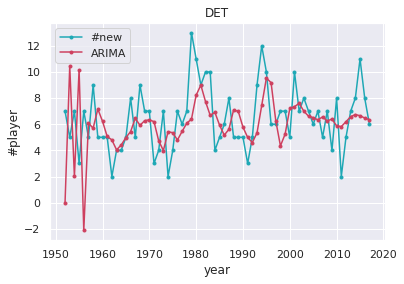

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   58
Model:               SARIMAX(1, 1, 3)   Log Likelihood                -119.546
Date:                Tue, 18 Dec 2018   AIC                            249.093
Time:                        12:52:10   BIC                            258.944
Sample:                    01-01-1952   HQIC                           252.881
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0327      1.035      0.032      0.975      -1.996       2.061
ma.L1         -1.2301      1.052     -1.169      0.242      -3.293       0.833
ma.L2          0.5414      1.241      0.436      0.6

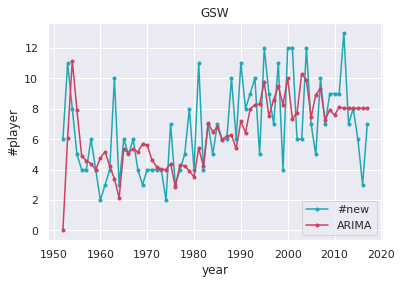

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   42
Model:               SARIMAX(1, 0, 3)   Log Likelihood                 -84.969
Date:                Tue, 18 Dec 2018   AIC                            179.938
Time:                        12:52:12   BIC                            188.126
Sample:                    01-01-1968   HQIC                           182.851
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0181      0.003    319.487      0.000       1.012       1.024
ma.L1         -1.3199   1527.669     -0.001      0.999   -2995.496    2992.857
ma.L2         -0.3460    500.973     -0.001      0.9

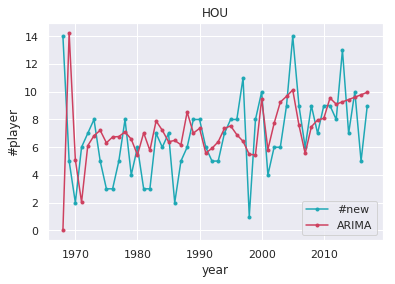

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   33
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 -62.724
Date:                Tue, 18 Dec 2018   AIC                            135.447
Time:                        12:52:13   BIC                            142.108
Sample:                    01-01-1977   HQIC                           137.484
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2753      2.095     -0.131      0.895      -4.381       3.831
ma.L1         -0.4604      2.013     -0.229      0.819      -4.406       3.485
ma.L2         -0.1602      1.519     -0.105      0.9

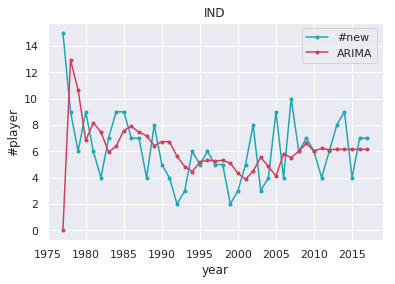

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   39
Model:               SARIMAX(2, 1, 3)   Log Likelihood                 -66.706
Date:                Tue, 18 Dec 2018   AIC                            145.412
Time:                        12:52:14   BIC                            154.570
Sample:                    01-01-1971   HQIC                           148.535
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0042      0.116     -0.036      0.971      -0.232       0.224
ar.L2         -0.7256      0.121     -5.991      0.000      -0.963      -0.488
ma.L1         -0.4454   1153.220     -0.000      1.0

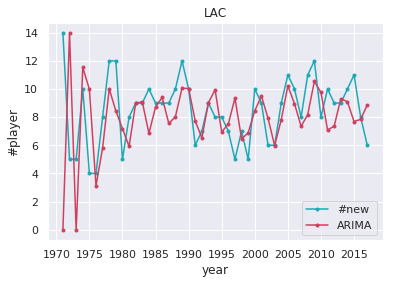

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   58
Model:               SARIMAX(1, 1, 3)   Log Likelihood                -108.074
Date:                Tue, 18 Dec 2018   AIC                            226.148
Time:                        12:52:15   BIC                            235.999
Sample:                    01-01-1952   HQIC                           229.936
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3662      0.390     -0.939      0.348      -1.131       0.398
ma.L1         -0.5616      0.375     -1.498      0.134      -1.296       0.173
ma.L2         -0.0089      0.328     -0.027      0.9

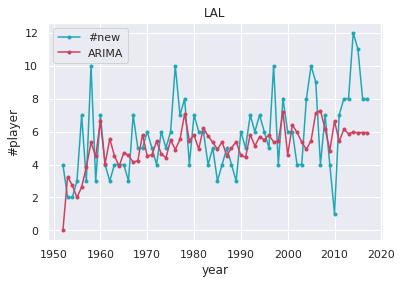

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   14
Model:               SARIMAX(2, 1, 3)   Log Likelihood                 -19.641
Date:                Tue, 18 Dec 2018   AIC                             51.282
Time:                        12:52:16   BIC                             52.465
Sample:                    01-01-1996   HQIC                            48.728
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5395      1.042     -0.518      0.605      -2.582       1.503
ar.L2         -0.2425      0.481     -0.504      0.614      -1.185       0.700
ma.L1          0.0800      3.270      0.024      0.9

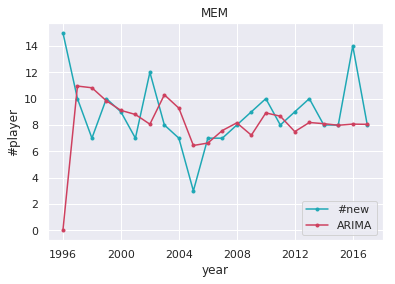

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   20
Model:               SARIMAX(3, 1, 3)   Log Likelihood                 -35.247
Date:                Tue, 18 Dec 2018   AIC                             84.494
Time:                        12:52:17   BIC                             89.450
Sample:                             0   HQIC                            84.441
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4211      0.268     -1.571      0.116      -0.947       0.104
ar.L2          0.1210      0.329      0.367      0.713      -0.525       0.767
ar.L3         -0.8799      0.213     -4.137      0.0

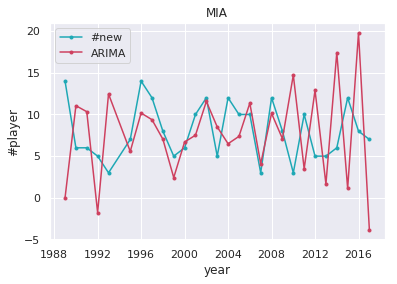

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   41
Model:               SARIMAX(2, 1, 3)   Log Likelihood                 -75.320
Date:                Tue, 18 Dec 2018   AIC                            162.640
Time:                        12:52:18   BIC                            172.141
Sample:                    01-01-1969   HQIC                           165.956
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2412      0.335      0.721      0.471      -0.415       0.897
ar.L2         -0.3584      0.267     -1.341      0.180      -0.882       0.166
ma.L1         -1.0904   7055.254     -0.000      1.0

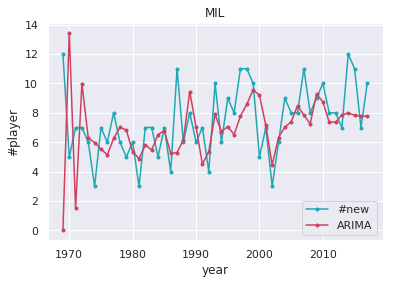

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   20
Model:               SARIMAX(2, 1, 3)   Log Likelihood                 -34.005
Date:                Tue, 18 Dec 2018   AIC                             80.011
Time:                        12:52:19   BIC                             84.259
Sample:                    01-01-1990   HQIC                            79.965
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1424      0.479     -2.384      0.017      -2.082      -0.203
ar.L2         -0.6599      0.410     -1.611      0.107      -1.463       0.143
ma.L1          0.0144   5565.922   2.59e-06      1.0

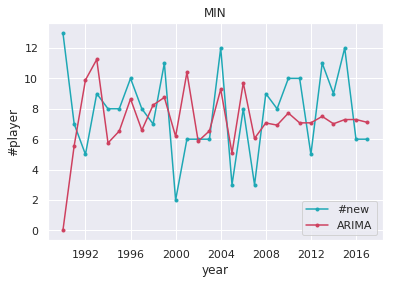

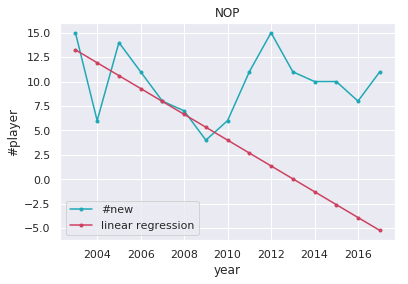

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   58
Model:               SARIMAX(1, 1, 3)   Log Likelihood                -114.847
Date:                Tue, 18 Dec 2018   AIC                            239.695
Time:                        12:52:20   BIC                            249.546
Sample:                    01-01-1952   HQIC                           243.483
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2807      0.748     -0.375      0.707      -1.747       1.185
ma.L1         -0.5068    766.831     -0.001      0.999   -1503.468    1502.454
ma.L2         -0.5826    377.805     -0.002      0.9

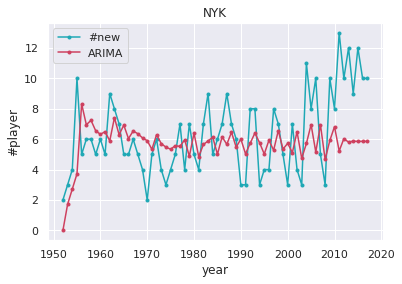

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   42
Model:               SARIMAX(2, 1, 3)   Log Likelihood                 -77.513
Date:                Tue, 18 Dec 2018   AIC                            167.025
Time:                        12:52:22   BIC                            176.691
Sample:                    01-01-1968   HQIC                           170.433
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2540      0.326     -0.780      0.436      -0.892       0.384
ar.L2         -0.4992      0.208     -2.404      0.016      -0.906      -0.092
ma.L1         -0.4749      0.382     -1.244      0.2

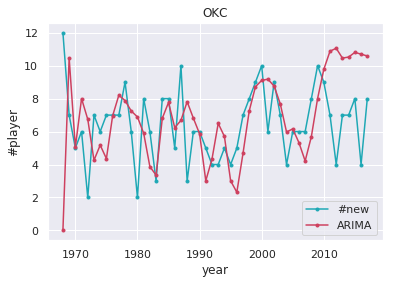

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   20
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 -34.242
Date:                Tue, 18 Dec 2018   AIC                             78.485
Time:                        12:52:22   BIC                             82.025
Sample:                    01-01-1990   HQIC                            78.447
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4684      2.384     -0.196      0.844      -5.142       4.205
ma.L1          0.3260   1147.793      0.000      1.000   -2249.307    2249.958
ma.L2         -1.0001    929.684     -0.001      0.9

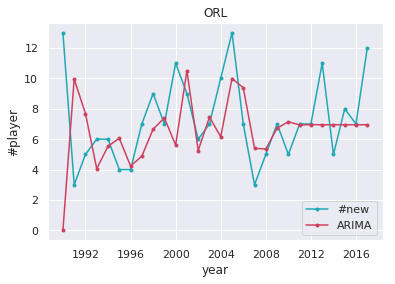

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   41
Model:               SARIMAX(2, 1, 3)   Log Likelihood                 -78.990
Date:                Tue, 18 Dec 2018   AIC                            169.980
Time:                        12:52:23   BIC                            179.482
Sample:                    01-01-1969   HQIC                           173.297
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1067      0.260     -0.411      0.681      -0.616       0.403
ar.L2         -0.4281      0.255     -1.680      0.093      -0.928       0.071
ma.L1         -0.9385    508.728     -0.002      0.9

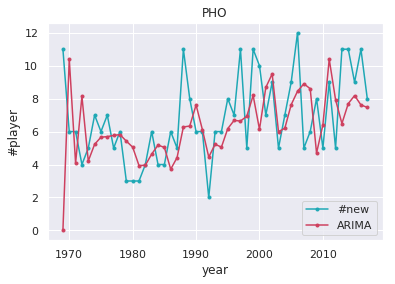

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   58
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -121.601
Date:                Tue, 18 Dec 2018   AIC                            255.202
Time:                        12:52:25   BIC                            267.024
Sample:                    01-01-1952   HQIC                           259.748
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7869      0.213     -3.700      0.000      -1.204      -0.370
ar.L2         -0.6120      0.154     -3.971      0.000      -0.914      -0.310
ma.L1          0.2711      0.230      1.177      0.2

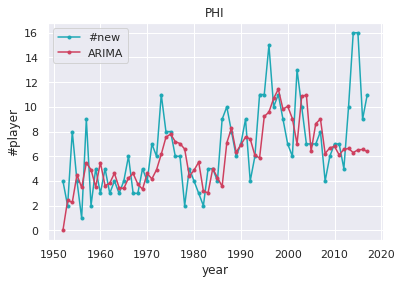

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   39
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 -76.742
Date:                Tue, 18 Dec 2018   AIC                            163.484
Time:                        12:52:26   BIC                            171.116
Sample:                    01-01-1971   HQIC                           166.087
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8608      0.141     -6.120      0.000      -1.136      -0.585
ma.L1          0.0267   5965.866   4.47e-06      1.000   -1.17e+04    1.17e+04
ma.L2         -0.9299   5806.525     -0.000      1.0

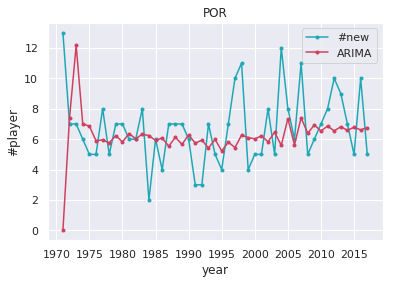

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   58
Model:               SARIMAX(1, 1, 3)   Log Likelihood                -118.318
Date:                Tue, 18 Dec 2018   AIC                            246.636
Time:                        12:52:27   BIC                            256.488
Sample:                    01-01-1952   HQIC                           250.425
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5430      0.505     -1.074      0.283      -1.534       0.448
ma.L1         -0.0725      0.528     -0.137      0.891      -1.107       0.962
ma.L2         -0.7188      0.294     -2.443      0.0

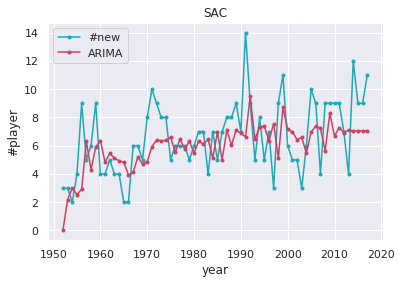

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   33
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 -62.214
Date:                Tue, 18 Dec 2018   AIC                            134.429
Time:                        12:52:28   BIC                            141.090
Sample:                    01-01-1977   HQIC                           136.465
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5930      0.165     -3.583      0.000      -0.917      -0.269
ma.L1          0.0145   1028.494   1.41e-05      1.000   -2015.797    2015.826
ma.L2         -0.7394   1013.577     -0.001      0.9

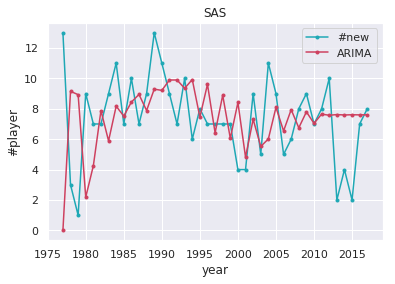

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   14
Model:               SARIMAX(3, 1, 3)   Log Likelihood                 -19.897
Date:                Tue, 18 Dec 2018   AIC                             53.794
Time:                        12:52:29   BIC                             55.174
Sample:                    01-01-1996   HQIC                            50.815
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8583      5.410     -0.159      0.874     -11.461       9.745
ar.L2         -0.7628      6.542     -0.117      0.907     -13.585      12.059
ar.L3          0.2193      5.230      0.042      0.9

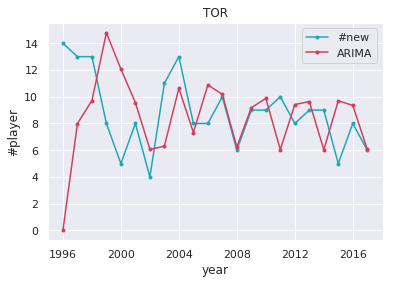

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   35
Model:               SARIMAX(3, 1, 3)   Log Likelihood                 -68.859
Date:                Tue, 18 Dec 2018   AIC                            151.718
Time:                        12:52:30   BIC                            161.526
Sample:                    01-01-1975   HQIC                           154.856
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6945      0.322     -2.159      0.031      -1.325      -0.064
ar.L2         -0.0775      0.414     -0.187      0.851      -0.889       0.734
ar.L3          0.5026      0.276      1.824      0.0

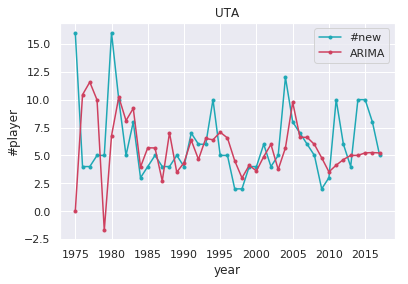

                           Statespace Model Results                           
Dep. Variable:                   #new   No. Observations:                   48
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 -90.345
Date:                Tue, 18 Dec 2018   AIC                            190.691
Time:                        12:52:32   BIC                            199.497
Sample:                    01-01-1962   HQIC                           193.938
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5014      0.606      0.828      0.408      -0.686       1.689
ma.L1          1.3115      2.084      0.629      0.529      -2.772       5.395
ma.L2         -3.1918      2.298     -1.389      0.1

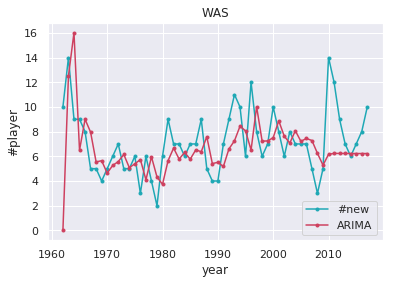

['NOP']
MAE 2.976268911187786
MSE 17.082811562733514
RMSE 4.133135802599948


In [9]:
# 2010 - 2017に出現するノード数を予測

x = "year"
years_1 = [i for i in range(1952, 2010)] # 訓練期間
target = [i for i in range(2010, 2018)] # 予測期間
years = [i for i in range(1952, 2018)] # 比較用

exception_tm = [] # 訓練期間が短い時系列はARIMAで推定できないため線形回帰する

team_ls = []
pred_ls = []
true_ls = []
for tm, graph in graph_tm.items():

    # 比較用
    y1 = "#new"
    new_player_1 = []
    years_2 = [] # チームが存在する年のみ扱う(全体)
    for year in years:
        diff = new_node(graph[year-1], graph[year])
        if diff != 0:
            new_player_1.append(float(diff))
            years_2.append(datetime.datetime(year, 1, 1))
    
    # 訓練用
    y2 = "ARIMA" # 季節変動性（周期性）はないものとしてARIMAモデルで推定を行う
    new_player_2 = []
    years_3 = [] # チームが存在する年のみ扱う(訓練期間)
    for year in years_1:
        diff = new_node(graph[year-1], graph[year])
        if diff != 0:
            new_player_2.append(float(diff)) # dtype=floatで読み込まないと、あとでARIMAモデル推定時にエラーとなる
            years_3.append(datetime.datetime(year, 1, 1)) # 日付形式にする
    
    # 訓練期間が10未満のものは線形回帰する
    if len(years_3) < 10:
        exception_tm.append(tm)
        y2 = "linear regression"
        
        # datetime形式からfloat型に変換(訓練期間)
        years_4 = []
        for year in years_3:
            years_4.append(float(str(year)[:4]))

        X = pd.DataFrame(years_4)
        Y = pd.DataFrame(new_player_2)
        
        model =linear_model.LinearRegression()
        model.fit(X, Y)

        # datetime形式からfloat型に変換(全体)
        years_4 = []
        for year in years_2:
            years_4.append(float(str(year)[:4]))

        px = np.array(years_4)[:,np.newaxis] # sklearnの仕様のため二次元numpy配列に変換
        py = model.predict(px)
        py = py.reshape(-1).tolist()
        
        history = {x:years_2, y1:new_player_1, y2:py}
        plot_history2(history, x, y1, y2, title=tm, ylabel="#player")
        
        for i in range(len(target)):
            true_ls.append(new_player_1[-1-i])
            pred_ls.append(py[-1-i])
            team_ls.append(tm)
        
        continue

    train = pd.DataFrame({'year':years_3, '#new':new_player_2}).set_index('year') # DataFrameに変換
    
    # 次数推定
    modelSelection = ParamEstimate(train)
    order = []
    for i in modelSelection['model'].tolist()[0].replace('order=', '').replace('(', '').replace(')', '').split(','):
        order.append(int(i))
    
    # パラメータ推定
    arima = sm.tsa.SARIMAX(
        train, order=(order[0],order[1],order[2]), 
        enforce_stationarity = False, 
        enforce_invertibility = False
    ).fit()
    
    print(arima.summary())

    # 予測 (予測期間は2010から2017であるが、確認用として全ての年にモデルを適用)
    #pred = arima.predict(years_2[0], years_2[-1]) たまにエラーが起こる
    pred = arima.predict(0, len(years_2)-1)
    
    # グラフ描画
    history = {x:years_2, y1:new_player_1, y2:pred}
    plot_history2(history, x, y1, y2, title=tm, ylabel="#player")
    
    for i in range(len(target)):
        true_ls.append(new_player_1[-1-i])        
        pred_ls.append(list(pred)[-1-i])
        team_ls.append(tm)

print(exception_tm)
print("MAE", mean_absolute_error(true_ls, pred_ls))
print("MSE", mean_squared_error(true_ls, pred_ls))
print("RMSE", np.sqrt(mean_squared_error(true_ls, pred_ls)))

result = pd.DataFrame({'team' : team_ls, 'true' : true_ls, 'pred' : pred_ls})
result = result.set_index('team')
result.to_csv(outputDir + "/1/ARIMA/ARIMA.csv")

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   58
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -132.646
Date:                Tue, 18 Dec 2018   AIC                            277.293
Time:                        12:52:33   BIC                            289.115
Sample:                    01-01-1952   HQIC                           281.839
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0978      0.427      2.571      0.010       0.261       1.934
ar.L2         -0.4563      0.258     -1.770      0.077      -0.962       0.049
ma.L1         -4.9477      4.532     -1.092      0.2

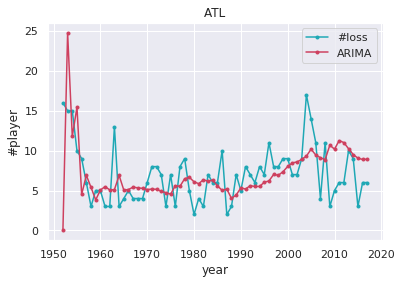

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   32
Model:               SARIMAX(2, 1, 3)   Log Likelihood                 -68.199
Date:                Tue, 18 Dec 2018   AIC                            148.398
Time:                        12:52:34   BIC                            156.173
Sample:                    01-01-1978   HQIC                           150.710
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4370      0.187     -7.679      0.000      -1.804      -1.070
ar.L2         -0.8273      0.189     -4.380      0.000      -1.197      -0.457
ma.L1          0.7812   8950.996   8.73e-05      1.0

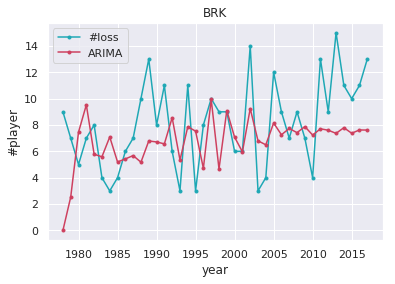

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   58
Model:               SARIMAX(1, 1, 3)   Log Likelihood                -117.333
Date:                Tue, 18 Dec 2018   AIC                            244.666
Time:                        12:52:36   BIC                            254.518
Sample:                    01-01-1952   HQIC                           248.454
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9939      0.069    -14.366      0.000      -1.130      -0.858
ma.L1          0.3306      0.159      2.085      0.037       0.020       0.641
ma.L2         -0.6593      0.179     -3.683      0.0

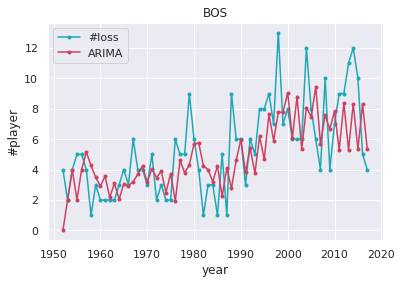

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   18
Model:               SARIMAX(3, 1, 3)   Log Likelihood                 -27.968
Date:                Tue, 18 Dec 2018   AIC                             69.935
Time:                        12:52:36   BIC                             73.890
Sample:                             0   HQIC                            69.123
                                 - 18                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1118      0.731      0.153      0.878      -1.321       1.545
ar.L2         -0.3237      0.428     -0.755      0.450      -1.163       0.516
ar.L3         -0.7313      0.532     -1.374      0.1

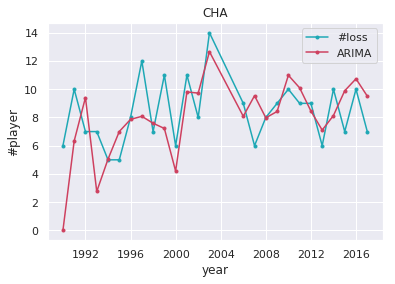

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   42
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 -89.345
Date:                Tue, 18 Dec 2018   AIC                            188.691
Time:                        12:52:38   BIC                            196.745
Sample:                    01-01-1968   HQIC                           191.530
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2491      2.199     -0.113      0.910      -4.559       4.060
ma.L1         -0.3993      2.163     -0.185      0.854      -4.638       3.839
ma.L2         -0.3896      1.410     -0.276      0.7

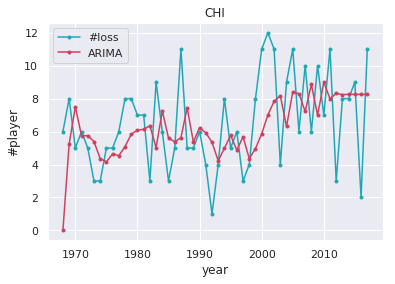

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   38
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 -77.094
Date:                Tue, 18 Dec 2018   AIC                            164.187
Time:                        12:52:38   BIC                            171.670
Sample:                    01-01-1972   HQIC                           166.705
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6708      0.340     -1.970      0.049      -1.338      -0.003
ma.L1          0.4768   1.46e+04   3.27e-05      1.000   -2.86e+04    2.86e+04
ma.L2         -0.5061   7632.443  -6.63e-05      1.0

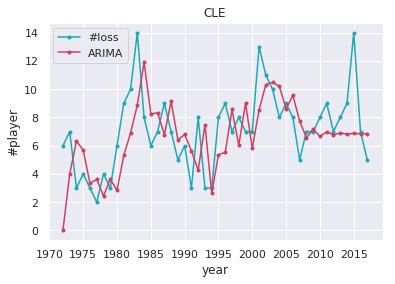

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   28
Model:               SARIMAX(2, 1, 3)   Log Likelihood                 -55.578
Date:                Tue, 18 Dec 2018   AIC                            123.155
Time:                        12:52:39   BIC                            129.968
Sample:                    01-01-1982   HQIC                           124.869
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7456      0.216     -3.450      0.001      -1.169      -0.322
ar.L2         -0.9932      0.257     -3.860      0.000      -1.497      -0.489
ma.L1          0.1541   7066.959   2.18e-05      1.0

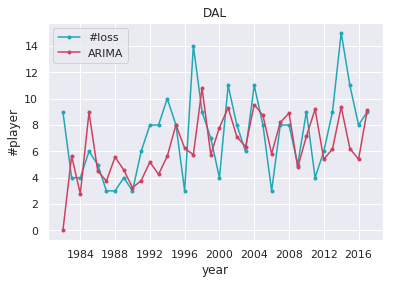

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   32
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 -62.285
Date:                Tue, 18 Dec 2018   AIC                            134.569
Time:                        12:52:40   BIC                            141.048
Sample:                    01-01-1978   HQIC                           136.496
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7808      0.226     -3.454      0.001      -1.224      -0.338
ma.L1          0.5498      0.270      2.036      0.042       0.021       1.079
ma.L2         -0.4226      0.183     -2.310      0.0

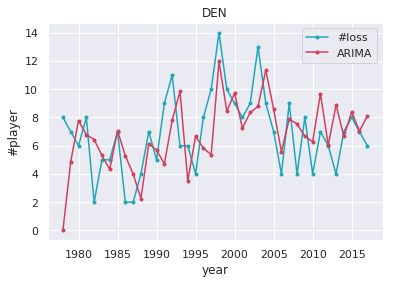

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   58
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -111.914
Date:                Tue, 18 Dec 2018   AIC                            237.828
Time:                        12:52:42   BIC                            251.620
Sample:                    01-01-1952   HQIC                           243.131
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1894      0.164     -7.265      0.000      -1.510      -0.868
ar.L2         -0.0609      0.263     -0.232      0.817      -0.576       0.454
ar.L3          0.4354      0.134      3.241      0.0

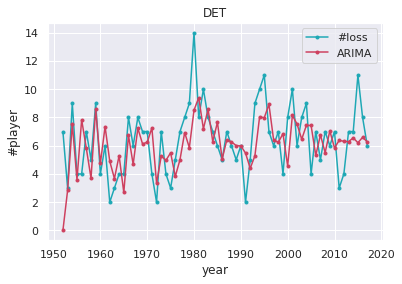

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   58
Model:               SARIMAX(1, 1, 3)   Log Likelihood                -113.423
Date:                Tue, 18 Dec 2018   AIC                            236.845
Time:                        12:52:43   BIC                            246.697
Sample:                    01-01-1952   HQIC                           240.634
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4517      0.258     -1.750      0.080      -0.958       0.054
ma.L1         -0.3355      0.247     -1.356      0.175      -0.820       0.149
ma.L2         -0.6041      0.155     -3.903      0.0

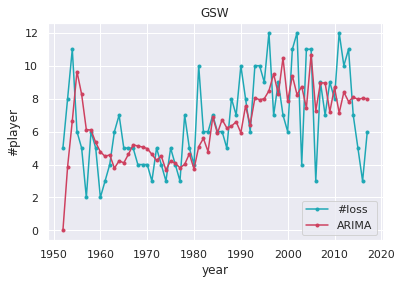

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   41
Model:               SARIMAX(1, 0, 3)   Log Likelihood                 -78.371
Date:                Tue, 18 Dec 2018   AIC                            166.742
Time:                        12:52:44   BIC                            174.797
Sample:                    01-01-1969   HQIC                           169.582
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0198      0.003    330.957      0.000       1.014       1.026
ma.L1         -1.5950   6680.552     -0.000      1.000   -1.31e+04    1.31e+04
ma.L2          0.2105   4060.643   5.18e-05      1.0

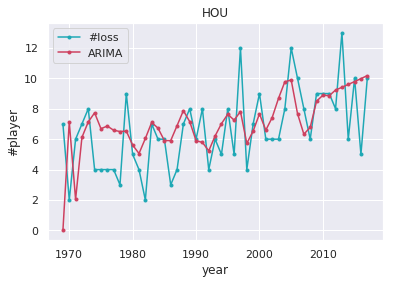

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   32
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 -58.326
Date:                Tue, 18 Dec 2018   AIC                            126.653
Time:                        12:52:45   BIC                            133.132
Sample:                    01-01-1978   HQIC                           128.580
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6395      0.495     -1.291      0.197      -1.610       0.331
ma.L1          0.0725      0.573      0.127      0.899      -1.050       1.195
ma.L2         -0.3578      0.399     -0.897      0.3

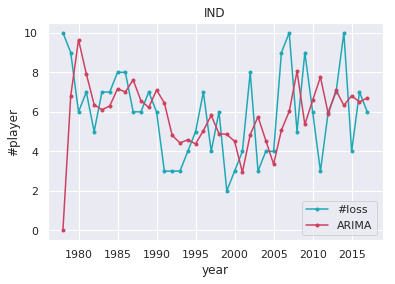

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   38
Model:               SARIMAX(2, 1, 3)   Log Likelihood                 -79.940
Date:                Tue, 18 Dec 2018   AIC                            171.880
Time:                        12:52:46   BIC                            180.859
Sample:                    01-01-1972   HQIC                           174.901
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6595      0.354     -1.862      0.063      -1.354       0.035
ar.L2         -0.4479      0.318     -1.409      0.159      -1.071       0.175
ma.L1         -0.2743   5.85e+04  -4.69e-06      1.0

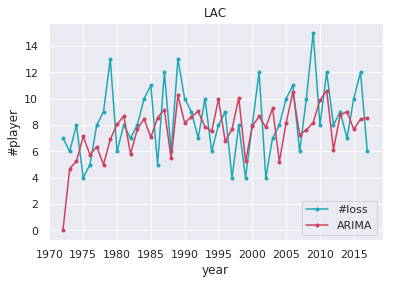

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   58
Model:               SARIMAX(1, 1, 3)   Log Likelihood                -110.766
Date:                Tue, 18 Dec 2018   AIC                            231.533
Time:                        12:52:47   BIC                            241.384
Sample:                    01-01-1952   HQIC                           235.321
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2678      0.492      0.545      0.586      -0.696       1.231
ma.L1         -1.1779      0.566     -2.081      0.037      -2.287      -0.068
ma.L2          0.5337      0.465      1.148      0.2

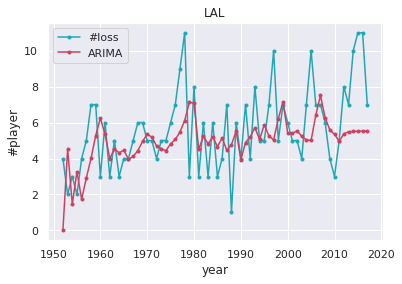

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   13
Model:               SARIMAX(1, 1, 2)   Log Likelihood                 -19.339
Date:                Tue, 18 Dec 2018   AIC                             46.677
Time:                        12:52:48   BIC                             47.466
Sample:                    01-01-1997   HQIC                            44.975
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5796      0.880     -0.659      0.510      -2.305       1.145
ma.L1       1.769e-05   6858.573   2.58e-09      1.000   -1.34e+04    1.34e+04
ma.L2         -1.0000   7510.686     -0.000      1.0

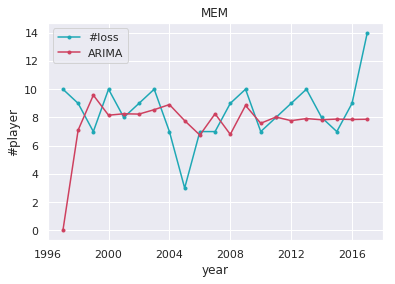

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   20
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 -35.364
Date:                Tue, 18 Dec 2018   AIC                             80.727
Time:                        12:52:49   BIC                             84.268
Sample:                    01-01-1990   HQIC                            80.690
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5007      0.294      1.706      0.088      -0.075       1.076
ma.L1         -0.4795   5289.300  -9.07e-05      1.000   -1.04e+04    1.04e+04
ma.L2         -1.7897   2167.468     -0.001      0.9

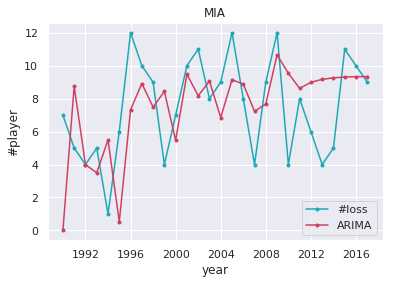

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   40
Model:               SARIMAX(3, 1, 3)   Log Likelihood                 -73.866
Date:                Tue, 18 Dec 2018   AIC                            161.731
Time:                        12:52:50   BIC                            172.619
Sample:                    01-01-1970   HQIC                           165.490
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2528      0.365     -3.434      0.001      -1.968      -0.538
ar.L2         -0.5334      0.476     -1.121      0.262      -1.466       0.399
ar.L3          0.2512      0.313      0.803      0.4

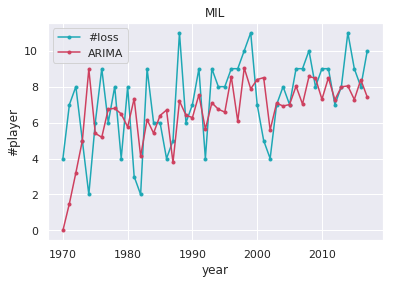

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   19
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 -33.213
Date:                Tue, 18 Dec 2018   AIC                             76.425
Time:                        12:52:51   BIC                             79.621
Sample:                    01-01-1991   HQIC                            76.130
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6665      1.420     -0.469      0.639      -3.450       2.117
ma.L1          0.3021      3.442      0.088      0.930      -6.445       7.049
ma.L2         -1.5012      4.075     -0.368      0.7

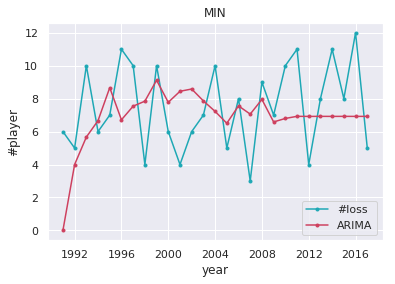

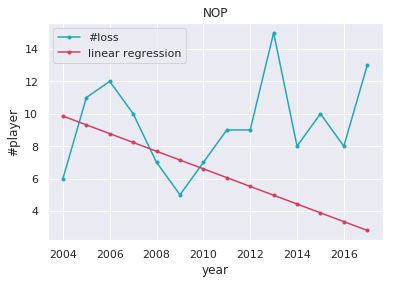

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   58
Model:               SARIMAX(1, 1, 3)   Log Likelihood                -122.460
Date:                Tue, 18 Dec 2018   AIC                            254.920
Time:                        12:52:52   BIC                            264.771
Sample:                    01-01-1952   HQIC                           258.708
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7269      0.560     -1.299      0.194      -1.824       0.370
ma.L1         -0.3010    901.287     -0.000      1.000   -1766.790    1766.188
ma.L2         -0.6439    630.318     -0.001      0.9

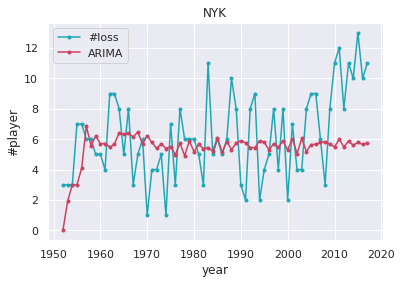

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   41
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 -78.922
Date:                Tue, 18 Dec 2018   AIC                            167.844
Time:                        12:52:53   BIC                            175.762
Sample:                    01-01-1969   HQIC                           170.608
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7144      0.359     -1.988      0.047      -1.419      -0.010
ma.L1         -0.0389      0.421     -0.092      0.926      -0.863       0.786
ma.L2         -0.8909      0.386     -2.307      0.0

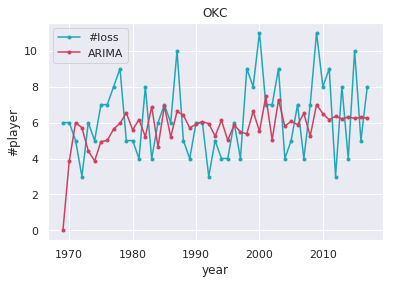

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   19
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 -31.363
Date:                Tue, 18 Dec 2018   AIC                             72.726
Time:                        12:52:54   BIC                             75.921
Sample:                    01-01-1991   HQIC                            72.430
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0431      0.152     -6.883      0.000      -1.340      -0.746
ma.L1          0.9515   1.51e+05   6.32e-06      1.000   -2.95e+05    2.95e+05
ma.L2         -0.9518   3716.985     -0.000      1.0

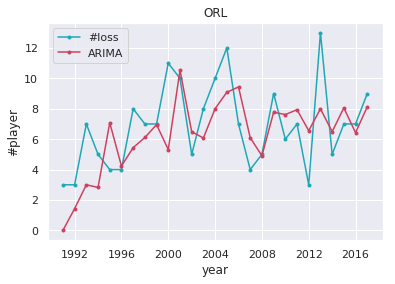

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   40
Model:               SARIMAX(3, 1, 3)   Log Likelihood                 -72.291
Date:                Tue, 18 Dec 2018   AIC                            158.582
Time:                        12:52:55   BIC                            169.469
Sample:                    01-01-1970   HQIC                           162.340
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0579      0.273     -3.877      0.000      -1.593      -0.523
ar.L2         -0.2073      0.379     -0.547      0.585      -0.950       0.536
ar.L3          0.4036      0.224      1.805      0.0

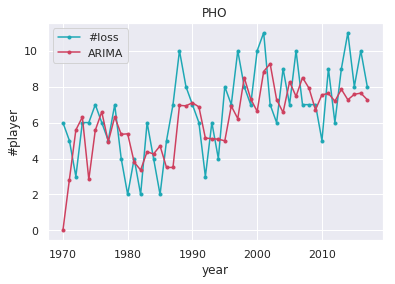

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   58
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -122.971
Date:                Tue, 18 Dec 2018   AIC                            257.941
Time:                        12:52:56   BIC                            269.763
Sample:                    01-01-1952   HQIC                           262.487
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8575      0.327     -2.619      0.009      -1.499      -0.216
ar.L2         -0.6297      0.287     -2.193      0.028      -1.192      -0.067
ma.L1          0.4102      0.337      1.217      0.2

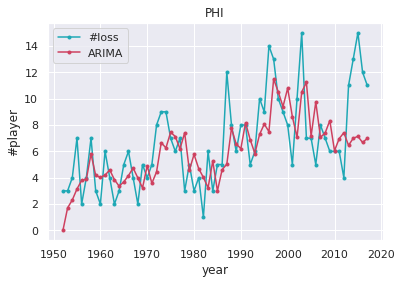

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   38
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 -73.947
Date:                Tue, 18 Dec 2018   AIC                            157.893
Time:                        12:52:57   BIC                            165.376
Sample:                    01-01-1972   HQIC                           160.411
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7597      0.195     -3.900      0.000      -1.141      -0.378
ma.L1         -0.0871      0.265     -0.329      0.743      -0.607       0.433
ma.L2         -0.7682      0.251     -3.059      0.0

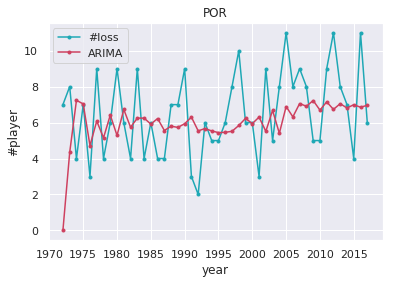

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   58
Model:               SARIMAX(1, 1, 3)   Log Likelihood                -124.144
Date:                Tue, 18 Dec 2018   AIC                            258.287
Time:                        12:52:58   BIC                            268.139
Sample:                    01-01-1952   HQIC                           262.076
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6499      0.168     -3.874      0.000      -0.979      -0.321
ma.L1          0.0050   7375.282   6.84e-07      1.000   -1.45e+04    1.45e+04
ma.L2         -0.9103   7338.048     -0.000      1.0

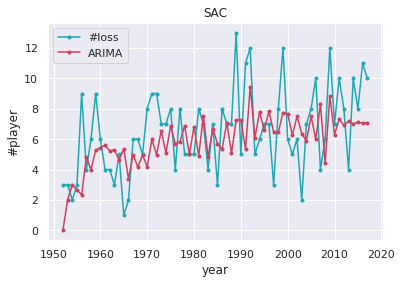

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   32
Model:               SARIMAX(2, 1, 3)   Log Likelihood                 -65.112
Date:                Tue, 18 Dec 2018   AIC                            142.223
Time:                        12:52:59   BIC                            149.998
Sample:                    01-01-1978   HQIC                           144.535
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9416      0.193     -4.870      0.000      -1.321      -0.563
ar.L2         -0.8890      0.159     -5.589      0.000      -1.201      -0.577
ma.L1          0.2319   1.59e+04   1.45e-05      1.0

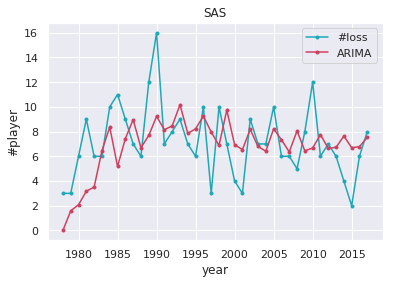

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   13
Model:               SARIMAX(1, 1, 2)   Log Likelihood                 -23.539
Date:                Tue, 18 Dec 2018   AIC                             55.079
Time:                        12:53:00   BIC                             55.867
Sample:                    01-01-1997   HQIC                            53.376
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1041      0.908     -0.115      0.909      -1.884       1.676
ma.L1         -0.7324   2.84e+04  -2.58e-05      1.000   -5.56e+04    5.56e+04
ma.L2         -0.2676   7592.099  -3.52e-05      1.0

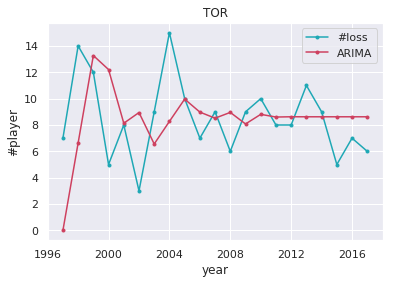

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   34
Model:               SARIMAX(3, 1, 3)   Log Likelihood                 -54.283
Date:                Tue, 18 Dec 2018   AIC                            122.566
Time:                        12:53:01   BIC                            132.137
Sample:                    01-01-1976   HQIC                           125.563
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4352      0.463     -0.940      0.347      -1.343       0.472
ar.L2          0.0266      0.534      0.050      0.960      -1.020       1.073
ar.L3          0.4283      0.294      1.458      0.1

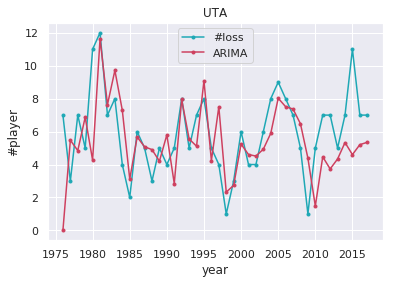

                           Statespace Model Results                           
Dep. Variable:                  #loss   No. Observations:                   47
Model:               SARIMAX(1, 1, 3)   Log Likelihood                -100.380
Date:                Tue, 18 Dec 2018   AIC                            210.759
Time:                        12:53:02   BIC                            219.448
Sample:                    01-01-1963   HQIC                           213.944
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0107      0.821      0.013      0.990      -1.599       1.620
ma.L1         -0.9489      0.788     -1.205      0.228      -2.493       0.595
ma.L2          0.2676      0.738      0.363      0.7

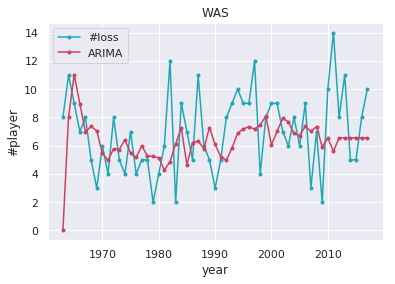

['NOP']
MAE 2.5540262310695843
MSE 10.49055846958446
RMSE 3.238913161785055


In [10]:
# 2010 - 2017に出現するノード数を予測

x = "year"
years_1 = [i for i in range(1952, 2010)] # 訓練期間
target = [i for i in range(2010, 2018)] # 予測期間
years = [i for i in range(1952, 2018)] # 比較用

exception_tm = [] # 訓練期間が短い時系列はARIMAで推定できないため線形回帰する

team_ls = []
pred_ls = []
true_ls = []
for tm, graph in graph_tm.items():

    # 比較用
    y1 = "#loss"
    loss_player_1 = []
    years_2 = [] # チームが存在する年のみ扱う(全体)
    for year in years:
        diff = loss_node(graph[year-1], graph[year])
        if diff != 0:
            loss_player_1.append(float(diff))
            years_2.append(datetime.datetime(year, 1, 1))
    
    # 訓練用
    y2 = "ARIMA" # 季節変動性（周期性）はないものとしてARIMAモデルで推定を行う
    loss_player_2 = []
    years_3 = [] # チームが存在する年のみ扱う(訓練期間)
    for year in years_1:
        diff = loss_node(graph[year-1], graph[year])
        if diff != 0:
            loss_player_2.append(float(diff)) # dtype=floatで読み込まないと、あとでARIMAモデル推定時にエラーとなる
            years_3.append(datetime.datetime(year, 1, 1)) # 日付形式にする
    
    # 訓練期間が10未満のものは線形回帰する
    if len(years_3) < 10:
        exception_tm.append(tm)
        y2 = "linear regression"
        
        # datetime形式からfloat型に変換(訓練期間)
        years_4 = []
        for year in years_3:
            years_4.append(float(str(year)[:4]))

        X = pd.DataFrame(years_4)
        Y = pd.DataFrame(loss_player_2)
        
        model =linear_model.LinearRegression()
        model.fit(X, Y)

        # datetime形式からfloat型に変換(全体)
        years_4 = []
        for year in years_2:
            years_4.append(float(str(year)[:4]))

        px = np.array(years_4)[:,np.newaxis] # sklearnの仕様のため二次元numpy配列に変換
        py = model.predict(px)
        py = py.reshape(-1).tolist()
        
        history = {x:years_2, y1:loss_player_1, y2:py}
        plot_history2(history, x, y1, y2, title=tm, ylabel="#player")
        
        for i in range(len(target)):
            true_ls.append(loss_player_1[-1-i])
            pred_ls.append(py[-1-i])
            team_ls.append(tm)
        
        continue

    train = pd.DataFrame({'year':years_3, '#loss':loss_player_2}).set_index('year') # DataFrameに変換
    
    # 次数推定
    modelSelection = ParamEstimate(train)
    order = []
    for i in modelSelection['model'].tolist()[0].replace('order=', '').replace('(', '').replace(')', '').split(','):
        order.append(int(i))
    
    # パラメータ推定
    arima = sm.tsa.SARIMAX(
        train, order=(order[0],order[1],order[2]), 
        enforce_stationarity = False, 
        enforce_invertibility = False
    ).fit()

    print(arima.summary())

    # 予測 (予測期間は2010から2017であるが、確認用として全ての年にモデルを適用)
    #pred = arima.predict(years_2[0], years_2[-1]) たまにエラーが起こる
    pred = arima.predict(0, len(years_2)-1)
    
    # グラフ描画
    history = {x:years_2, y1:loss_player_1, y2:pred}
    plot_history2(history, x, y1, y2, title=tm, ylabel="#player")
    
    for i in range(len(target)):
        true_ls.append(loss_player_1[-1-i])        
        pred_ls.append(list(pred)[-1-i])
        team_ls.append(tm)

print(exception_tm)
print("MAE", mean_absolute_error(true_ls, pred_ls))
print("MSE", mean_squared_error(true_ls, pred_ls))
print("RMSE", np.sqrt(mean_squared_error(true_ls, pred_ls)))

result = pd.DataFrame({'team' : team_ls, 'true' : true_ls, 'pred' : pred_ls})
result = result.set_index('team')
result.to_csv(outputDir + "/2/ARIMA/ARIMA.csv")